In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
import datetime as dt
from math import ceil, sqrt
from Utils import *
pd.set_option('max_colwidth', None)
from EvaluationMetric import *
from xgboost import XGBClassifier

In [181]:
def comparemodels(train_X, train_y, val_X, test_X, generaldescription, unbalanced = True):
    res = []

    model1 = DecisionTreeClassifier(max_leaf_nodes= 6, random_state=1)
    model1.fit(train_X, train_y)
    preds_val1 = model1.predict(val_X)
    model_test1 = model1.predict(test_X)
    description = generaldescription+"max_leaf_nodes : 6 + with date columns"
    metrics1 = listmetrics(val_y, preds_val1, "DecisionTreeClassifier", description)
    m1Public = [0.666666666, 0.666666666]
    m1Private = [0.661016949, 0.661016949]
    res.append(metrics1)
    df1 = getscoreforcsv(index_val, model_test1, name_file = "TreeClass5leaf.csv")


    model2 = RandomForestClassifier(n_estimators=36, criterion = 'entropy', random_state=1)
    model2.fit(train_X, train_y)
    preds_val2 = model2.predict(val_X)
    model_test2 = model2.predict(test_X)
    description = generaldescription+"n_estimators : 36 + Entropy"
    metrics2 = listmetrics(val_y, preds_val2, "Random Forest Classifier", description)
    m2Public = [0.690909090, 0.666666666]
    m2Private = [0.649122807, 0.649122807]
    res.append(metrics2)
    df2 = getscoreforcsv(index_val, model_test2, name_file = "RandomForestN36Entropy.csv")


    ##################ICi donne un 0.71 de scrore !!! mtn comprendre pq en diminuant les feature si bon score mais que pour lui !############
    #Ne fonctionne pas bien quadn le training set est entier. 
    if (unbalanced) : 
        model2 = XGBClassifier(scale_pos_weight=22, random_state=1)
    else : 
        model2 = XGBClassifier(random_state=1)
    model2.fit(train_X, train_y)
    preds_val2 = model2.predict(val_X)
    model_test2 = model2.predict(test_X)
    description = generaldescription+"scale_pos_weight = 22"
    metrics2 = listmetrics(val_y, preds_val2, "XGBClassifier", description)
    m3Public = [0.677419354, 0.711864406]
    m3Private = [0.676923076,  0.715447154]
    res.append(metrics2)
    df2 = getscoreforcsv(index_val, model_test2, name_file = "XGBClassifierW22.csv")
    
    if (unbalanced) :

        #oversamplesimple
        X_con = pd.concat([train_X, train_y], axis=1) 
        not_fraud = X_con[X_con.FraudResult==0]
        fraud = X_con[X_con.FraudResult==1]
        fraud_upsampled = resample(fraud, replace=True, n_samples=len(not_fraud), # match number in majority class
                                random_state=1) # reproducible results
        upsampled = pd.concat([not_fraud, fraud_upsampled])
        train_y_over_sampled = upsampled.FraudResult
        train_X_over_sampled = upsampled.drop('FraudResult', axis=1)
        upsampledmodel = RandomForestClassifier(n_estimators=36, criterion = 'entropy', random_state=1)
        upsampledmodel.fit(train_X_over_sampled, train_y_over_sampled)
        upsampled_pred = upsampledmodel.predict(val_X)
        model_test = upsampledmodel.predict(OH_X_test)
        description = generaldescription+"upsampled, n_estimators=36, criterion = entropy"
        metrics = listmetrics(val_y, upsampled_pred, "RandomForestClassifierUpperSampling", description)
        m4Public = [0.678571428, 0.642857142]
        m4Private = [0.637168141, 0.620689655]
        res.append(metrics)
        df = getscoreforcsv(index_val, model_test, name_file = "RandomForestClassifierUpSample.csv")

        #Undersampling
        not_fraud_downsampled  = resample(not_fraud, replace=False, n_samples=len(fraud), # match number in minority  class
                                random_state=1) # reproducible results
        downsampled  = pd.concat([not_fraud_downsampled , fraud])
        train_y_undersampled = downsampled.FraudResult
        train_X_undersampled = downsampled.drop('FraudResult', axis=1)
        undersampled = RandomForestClassifier(n_estimators=36, criterion = 'entropy', random_state=1)
        undersampled.fit(train_X_over_sampled, train_y_over_sampled)
        undersampled_pred = undersampled.predict(val_X)
        model_test = undersampled.predict(OH_X_test)
        description = generaldescription+"undersampled, n_estimators=36, criterion = entropy"
        metrics = listmetrics(val_y, undersampled_pred, "RandomForestClassifierUnderSampling", description)
        m5Public = [0.549019607, 0.642857142]
        m5Private = [0.480769230, 0.620689655]
        res.append(metrics)
        df = getscoreforcsv(index_val, model_test, name_file = "RandomForestClassifierUndersampled.csv")
        
        loldPublics = [m1Public, m2Public, m3Public, m4Public, m5Public]
        loldPrivate = [m1Private, m2Private, m3Private, m4Private, m5Private]
        
    else:
        loldPublics = [m1Public, m2Public, m3Public]
        loldPrivate = [m1Private, m2Private, m3Private]
        


    dfres = listmetricsintodf(res)
    dfres["OldPublicScore"] = loldPublics
    dfres["OldPrivateScore"] = loldPrivate
    dfres["MeanOurMetrics"] = dfres[['Precision', 'Recall','F1-score','Mcc']].mean(axis=1)
    dfres.to_csv('output/resultatsTestEverything.csv', mode='a',index=False,header = False) 
    return dfres

# Test de different model with different Data Here
## 1. The reference model

In [182]:
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
raw_data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

#attribut initialization
cols_unique_value = [] #Will be droped
for col in raw_data.columns : 
    if len(raw_data[col].unique()) == 1 :
        cols_unique_value.append(col)

medium_cardianlity_cols = ["ProductId"]

#Data transformation
raw_data['TransactionStartTime'] = pd.to_datetime(raw_data['TransactionStartTime'])
X_test['TransactionStartTime'] = pd.to_datetime(X_test['TransactionStartTime'])

#Data cleaning
data = raw_data.copy()
data = data.dropna(axis=0) #Drop observations/rows with missing values
X_test=X_test.dropna(axis=0)
data.drop(cols_unique_value, axis=1, inplace=True)
X_test.drop(cols_unique_value, axis=1, inplace=True)

#Prepare index for the submission
index_val = list(X_test.TransactionId.values.tolist())

#Set the df index to the Transction Id
data = transactioId_to_index(data)
X_test = transactioId_to_index(X_test)

#Adding data
data = adding_date_col(data, 'TransactionStartTime')
X_test = adding_date_col(X_test, 'TransactionStartTime')


# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in data.columns if data[cname].nunique() < 15 and 
                        data[cname].dtype == "object"]
low_cardinality_cols.append('PricingStrategy')

#transform columns BatchId_54 to number
    #transform columns BatchId_54 to number
id_cols = data.filter(like="Id").columns.tolist()
data[id_cols] = data[id_cols].astype(str).apply(lambda x: x.str.replace(x.name + "_", "")).astype(int)
X_test[id_cols] = X_test[id_cols].astype(str).apply(lambda x: x.str.replace(x.name + "_", "")).astype(int)

data['PricingStrategy'] = data['PricingStrategy'].astype('int')
X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('int')
data['Value'] = data['Value'].astype('float')
X_test['Value'] = X_test['Value'].astype('float')

X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('str')
data['PricingStrategy'] = data['PricingStrategy'].astype('str')

#Data splitting
y = data.FraudResult #The target label
X = data.copy()
X.drop(['FraudResult'], axis=1, inplace=True) #Only the features data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

cat_cols = [col for col in X.columns if X[col].dtype == "object"]#liste of obejct columns
cat_cols.append("PricingStrategy")#pcq mm si c'est un chiffre il faut le considérer comme une catégorie


OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[low_cardinality_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[low_cardinality_cols]))
OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_valid.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()

# One-hot encoding removed index; put it back
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index
OH_cols_test.index = X_test.index

OH_cols_train[list(OH_cols_train.columns)] = OH_cols_train[list(OH_cols_train.columns)].astype(int)
OH_cols_valid[list(OH_cols_valid.columns)] = OH_cols_valid[list(OH_cols_valid.columns)].astype(int)
OH_cols_test[list(OH_cols_test.columns)] = OH_cols_test[list(OH_cols_test.columns)].astype(int)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_X.drop(low_cardinality_cols, axis=1)
num_X_valid = val_X.drop(low_cardinality_cols, axis=1)
num_X_test = X_test.drop(low_cardinality_cols, axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# Problème de string
OH_X_train.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_valid.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_test.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

train_X = OH_X_train
val_X = OH_X_valid
test_X = OH_X_test
X_entier = pd.concat([train_X, val_X])

referenceresult = comparemodels(train_X, train_y, val_X, test_X, "The reference")
referenceresult["PublicScore"] = [0.666666666, 0.690909090, 0.677419354, 0.678571428, 0.549019607]
referenceresult["PrivateScore"] = [0.661016949, 0.649122807, 0.676923076, 0.637168141, 0.480769230]
referenceresult

done
done
done
done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,DecisionTreeClassifier,The referencemax_leaf_nodes : 6 + with date columns,2023-05-07 16:20:04.472061,0.891892,0.825,0.857143,0.016578,0.857566,0.666667,0.661017,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.857900
1,Random Forest Classifier,The referencen_estimators : 36 + Entropy,2023-05-07 16:20:05.658312,0.813953,0.875,0.843373,0.019592,0.843655,0.690909,0.649123,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.843995
2,XGBClassifier,The referencescale_pos_weight = 22,2023-05-07 16:20:07.080323,0.822222,0.925,0.870588,0.016578,0.871874,0.677419,0.676923,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.872421
3,RandomForestClassifierUpperSampling,"The referenceupsampled, n_estimators=36, criterion = entropy",2023-05-07 16:20:09.463452,0.777778,0.875,0.823529,0.022606,0.824649,0.678571,0.637168,"[0.678571428, 0.642857142]","[0.637168141, 0.620689655]",0.825239
4,RandomForestClassifierUnderSampling,"The referenceundersampled, n_estimators=36, criterion = entropy",2023-05-07 16:20:11.766025,0.777778,0.875,0.823529,0.022606,0.824649,0.549020,0.480769,"[0.549019607, 0.642857142]","[0.48076923, 0.620689655]",0.825239


# Niko Test

# Small preprocessing

In [183]:
df = pd.read_csv("input/training.csv")
data = df.copy()
y_train = df["FraudResult"]
X_test = pd.read_csv("input/test.csv")
X_valid = X_test.copy()
sample_submission = pd.read_csv("input/sample_submission.csv")

In [184]:
# Count the number of unique entries in each column
unique_counts = data.nunique()

# Select only columns with more than one unique entry
drop_cols = unique_counts[unique_counts == 1].index.tolist()
print("Dropping column with one unique values: ", drop_cols)

# Drop the selected columns
data = data.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)

# Get a list of column names that contain the string "id" in their name
id_cols = data.filter(like="Id").columns.tolist()

# Print the list of column names
print("Converting columns with Id: ", id_cols)

# Remove column name prefix and convert to integer data type
data[id_cols] = (
    data[id_cols]
    .astype(str)
    .apply(lambda x: x.str.replace(x.name + "_", ""))
    .astype(int)
)
X_test[id_cols] = (
    X_test[id_cols]
    .astype(str)
    .apply(lambda x: x.str.replace(x.name + "_", ""))
    .astype(int)
)

# convert TransactionStartTime column to datetime format
data["TransactionStartTime"] = pd.to_datetime(
    df["TransactionStartTime"], format="%Y-%m-%dT%H:%M:%SZ"
)
X_test["TransactionStartTime"] = pd.to_datetime(
    X_test["TransactionStartTime"], format="%Y-%m-%dT%H:%M:%SZ"
)

# extract date and time features
data["TransactionDayOfWeek"] = data["TransactionStartTime"].dt.dayofweek
data["TransactionDayOfMonth"] = data["TransactionStartTime"].dt.day
data["TransactionHour"] = data["TransactionStartTime"].dt.hour
data["TransactionMinute"] = data["TransactionStartTime"].dt.minute

X_test["TransactionDayOfWeek"] = X_test["TransactionStartTime"].dt.dayofweek
X_test["TransactionDayOfMonth"] = X_test["TransactionStartTime"].dt.day
X_test["TransactionHour"] = X_test["TransactionStartTime"].dt.hour
X_test["TransactionMinute"] = X_test["TransactionStartTime"].dt.minute

# drop TransactionStartTime
data = data.drop("TransactionStartTime", axis=1)
X_test = X_test.drop("TransactionStartTime", axis=1)

# Factorize the "ProductCategory" column
data['ProductCategory'] = pd.factorize(data['ProductCategory'])[0] + 1
X_test['ProductCategory'] = pd.factorize(X_test['ProductCategory'])[0] + 1
# Convert the "ProductCategory" column to integer data type
data['ProductCategory'] = data['ProductCategory'].astype(int)
X_test['ProductCategory'] = X_test['ProductCategory'].astype(int)

# Removing redundant data
data["Expense"] = data["Amount"] < 0
data.Expense = data.Expense.astype(int)
data = data.drop("Amount", axis=1)

X_test["Expense"] = X_test["Amount"] < 0
X_test.Expense = X_test.Expense.astype(int)
X_test = X_test.drop("Amount", axis=1)

# Continous value should be float
data["Value"] = data["Value"].astype(float)
X_test["Value"] = X_test["Value"].astype(float)

Dropping column with one unique values:  ['CurrencyCode', 'CountryCode']
Converting columns with Id:  ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ChannelId']


# Scenario 1: With All columns

In [185]:
# Evaluate data (drop FraudResult before)
X_1 = data.drop("FraudResult", axis=1)
# mi_score = make_mi_scores(data, y_train)
train_X, val_X, train_y, val_y = train_test_split(X_1, y_train, random_state = 0)
referenceresult = comparemodels(train_X, train_y, val_X, X_test, "The reference", unbalanced=False)
referenceresult

done
done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,DecisionTreeClassifier,The referencemax_leaf_nodes : 6 + with date columns,2023-05-07 16:20:13.427004,0.942857,0.825,0.880000,0.013564,0.881780,NaN,NaN,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.882409
1,Random Forest Classifier,The referencen_estimators : 36 + Entropy,2023-05-07 16:20:15.235793,0.760870,0.875,0.813953,0.024113,0.815615,NaN,NaN,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.816359
2,XGBClassifier,The referencescale_pos_weight = 22,2023-05-07 16:20:16.337648,0.900000,0.900,0.900000,0.012057,0.899832,NaN,NaN,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.899958


# Scenario 2: Dropping Unique ID columns

In [186]:
dropping_cols = ["TransactionId", "BatchId", "AccountId", "CustomerId", "SubscriptionId"]

for col in dropping_cols:
    data = data.drop(col, axis=1)
    X_test = X_test.drop(col, axis=1)

In [187]:
# Evaluate data (drop FraudResult before)
X_2 = data.drop("FraudResult", axis=1)
# mi_score = make_mi_scores(data, y_train)
train_X, val_X, train_y, val_y = train_test_split(X_2, y_train, random_state = 0)
referenceresult = comparemodels(train_X, train_y, val_X, X_test, "The reference", unbalanced=False)
referenceresult

done
done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,DecisionTreeClassifier,The referencemax_leaf_nodes : 6 + with date columns,2023-05-07 16:20:16.580168,0.894737,0.85,0.871795,0.015071,0.871873,NaN,NaN,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.872101
1,Random Forest Classifier,The referencen_estimators : 36 + Entropy,2023-05-07 16:20:17.428771,0.829268,0.85,0.839506,0.019592,0.839298,NaN,NaN,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.839518
2,XGBClassifier,The referencescale_pos_weight = 22,2023-05-07 16:20:18.108066,0.900000,0.90,0.900000,0.012057,0.899832,NaN,NaN,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.899958


# Scenario 3: Adding new features

In [188]:
categorical_col = ["ProviderId", "ProductCategory", "ChannelId", "PricingStrategy"]
mean_std_col = ['ProductId', 'Expense', "ProviderId", "ProductCategory", "ChannelId", "PricingStrategy"]

# Compute mean and standard deviation for specific features
for feature in mean_std_col:
    # Compute the mean and standard deviation of transactions for each feature
    feature_avg_values = data.groupby(feature)['Value'].mean()
    feature_std_values = data.groupby(feature)['Value'].std()
    data[f"{feature}_mean_amount"] = data[feature].apply(lambda x: feature_avg_values[x])
    data[f"{feature}_std_amount"] = data[feature].apply(lambda x: feature_std_values[x])
    
for feature in mean_std_col:
    # Compute the mean and standard deviation of transactions for each feature
    feature_avg_values = X_test.groupby(feature)['Value'].mean()
    feature_std_values = X_test.groupby(feature)['Value'].std()
    X_test[f"{feature}_mean_amount"] = X_test[feature].apply(lambda x: feature_avg_values[x])
    X_test[f"{feature}_std_amount"] = X_test[feature].apply(lambda x: feature_std_values[x])

In [189]:
# Remove the rows that contain missing values
data.dropna(inplace=True)

In [190]:
# OneHot Encode categorical features
data = pd.get_dummies(data, columns=categorical_col)
# Adding missing col
data["ChannelId_4"] = False
data["PricingStrategy_3"] = False
X_test = pd.get_dummies(X_test, columns=categorical_col)
# Adding missing col
X_test["PricingStrategy_3"] = False

In [191]:
# Convert the boolean columns to integer columns
bool_cols = data.select_dtypes(include=bool).columns.tolist()
data[bool_cols] = data[bool_cols].astype(int)

bool_cols = X_test.select_dtypes(include=bool).columns.tolist()
X_test[bool_cols] = X_test[bool_cols].astype(int)

In [192]:
y_train = data.FraudResult
data.drop("FraudResult", inplace=True, axis=1)

In [193]:
mi_score = make_mi_scores(data, y_train)

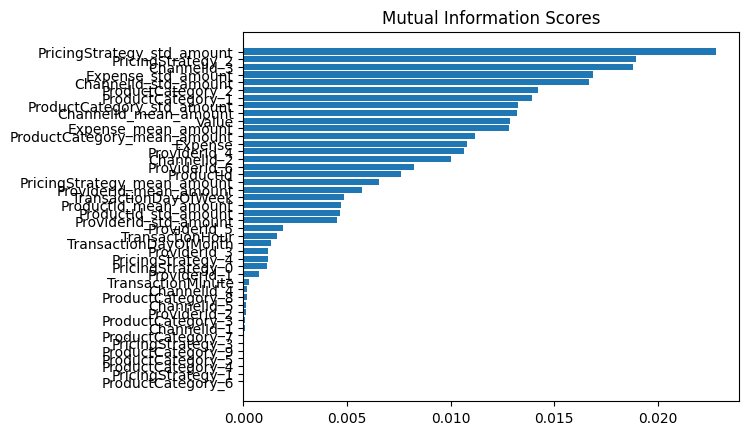

In [194]:
plot_mi_scores(mi_score)

In [195]:
# Reorder the columns in alphabetical order
data = data.sort_index(axis=1)
X_test = X_test.sort_index(axis=1)

# Evaluate data
X_3 = data.copy()

train_X, val_X, train_y, val_y = train_test_split(X_3, y_train, random_state = 0)
referenceresult = comparemodels(train_X, train_y, val_X, X_test, "The reference", unbalanced=False)
referenceresult

done
done


OSError: [Errno 22] Invalid argument: 'output/XGBClassifierW22.csv'

# Removing Low MI columns

In [ ]:
mi_scores = make_mi_scores(X_3 , y_train)

In [ ]:
mediumMI = list(mi_scores[mi_scores<0.01].index)
X_3.drop(mediumMI, inplace=True, axis=1, errors='ignore')
X_test_3 = X_test.copy()
X_test_3.drop(mediumMI, inplace=True, axis=1, errors='ignore')

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X_3, y_train, random_state = 0)
referenceresult = comparemodels(train_X, train_y, val_X, X_test_3, "The reference", unbalanced=False)
referenceresult

done
done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,DecisionTreeClassifier,The referencemax_leaf_nodes : 6 + with date columns,2023-05-07 15:59:38.040325,0.969697,0.761905,0.853333,0.016578,0.859335,NaN,NaN,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.861068
1,Random Forest Classifier,The referencen_estimators : 36 + Entropy,2023-05-07 15:59:38.659894,0.968750,0.738095,0.837838,0.018085,0.845369,NaN,NaN,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.847513
2,XGBClassifier,The referencescale_pos_weight = 22,2023-05-07 15:59:39.331488,0.970588,0.785714,0.868421,0.015071,0.873080,NaN,NaN,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.874451


In [196]:
X_4 = data.copy()
X_test_4 = X_test.copy()

In [197]:
lowMI = list(mi_scores[mi_scores<0.001].index)
X_4.drop(lowMI, inplace=True, axis=1, errors='ignore')
X_test_4.drop(mediumMI, inplace=True, axis=1, errors='ignore')

In [199]:
X_test_4.shape

(45019, 15)

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X_4, y_train, random_state = 0)
referenceresult = comparemodels(train_X, train_y, val_X, X_test_4, "The reference", unbalanced=False)
referenceresult

## 2. Play with deleting the low MI columns

In [145]:
# Supprimer les MI trop faible
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
raw_data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

#attribut initialization
cols_unique_value = [] #Will be droped
for col in raw_data.columns : 
    if len(raw_data[col].unique()) == 1 :
        cols_unique_value.append(col)

medium_cardianlity_cols = ["ProductId"]

#Data transformation
raw_data['TransactionStartTime'] = pd.to_datetime(raw_data['TransactionStartTime'])
X_test['TransactionStartTime'] = pd.to_datetime(X_test['TransactionStartTime'])

#Data cleaning
data = raw_data.copy()
data = data.dropna(axis=0) #Drop observations/rows with missing values
X_test=X_test.dropna(axis=0)
data.drop(cols_unique_value, axis=1, inplace=True)
X_test.drop(cols_unique_value, axis=1, inplace=True)

#Prepare index for the submission
index_val = list(X_test.TransactionId.values.tolist())

#Set the df index to the Transction Id
data = transactioId_to_index(data)
X_test = transactioId_to_index(X_test)

#Adding data
data = adding_date_col(data, 'TransactionStartTime')
X_test = adding_date_col(X_test, 'TransactionStartTime')


# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in data.columns if data[cname].nunique() < 15 and 
                        data[cname].dtype == "object"]
low_cardinality_cols.append('PricingStrategy')

#transform columns BatchId_54 to number
    #transform columns BatchId_54 to number
id_cols = data.filter(like="Id").columns.tolist()
data[id_cols] = data[id_cols].astype(str).apply(lambda x: x.str.replace(x.name + "_", "")).astype(int)
X_test[id_cols] = X_test[id_cols].astype(str).apply(lambda x: x.str.replace(x.name + "_", "")).astype(int)

data['PricingStrategy'] = data['PricingStrategy'].astype('int')
X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('int')
data['Value'] = data['Value'].astype('float')
X_test['Value'] = X_test['Value'].astype('float')

X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('str')
data['PricingStrategy'] = data['PricingStrategy'].astype('str')

#Data splitting
y = data.FraudResult #The target label
X = data.copy()
X.drop(['FraudResult'], axis=1, inplace=True) #Only the features data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

cat_cols = [col for col in X.columns if X[col].dtype == "object"]#liste of obejct columns
cat_cols.append("PricingStrategy")#pcq mm si c'est un chiffre il faut le considérer comme une catégorie


OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[low_cardinality_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[low_cardinality_cols]))
OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_valid.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()

# One-hot encoding removed index; put it back
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index
OH_cols_test.index = X_test.index

OH_cols_train[list(OH_cols_train.columns)] = OH_cols_train[list(OH_cols_train.columns)].astype(int)
OH_cols_valid[list(OH_cols_valid.columns)] = OH_cols_valid[list(OH_cols_valid.columns)].astype(int)
OH_cols_test[list(OH_cols_test.columns)] = OH_cols_test[list(OH_cols_test.columns)].astype(int)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_X.drop(low_cardinality_cols, axis=1)
num_X_valid = val_X.drop(low_cardinality_cols, axis=1)
num_X_test = X_test.drop(low_cardinality_cols, axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# Problème de string
OH_X_train.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_valid.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_test.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

train_X = OH_X_train
val_X = OH_X_valid
test_X = OH_X_test
X_entier = pd.concat([train_X, val_X])

mi_scores = make_mi_scores(X_entier , y)

verylowMI = list(mi_scores[mi_scores<0.0001].index)
lowMI = list(mi_scores[(mi_scores>=0.0001)&(mi_scores<0.001)].index)
mediumMI = list(mi_scores[(mi_scores>=0.001)&(mi_scores<0.01)].index)
highMI = list(mi_scores[mi_scores>=0.01].index)

### 2.1 Delecte the very low MI columns

In [5]:
train_X.drop(verylowMI, inplace=True, axis=1, errors='ignore')
val_X.drop(verylowMI, inplace=True, axis=1, errors='ignore')
test_X.drop(verylowMI, inplace=True, axis=1, errors='ignore')
X_entier.drop(verylowMI, inplace=True, axis=1, errors='ignore')

withoutverylowMI = comparemodels(train_X, train_y, val_X, test_X, "Delete very low MI")
withoutverylowMI["PublicScore"] = [0.666666666, 0.666666666, 0.711864406, 0.642857142, 0.642857142]
withoutverylowMI["PrivateScore"] = [0.661016949, 0.649122807, 0.715447154, 0.620689655, 0.620689655]
withoutverylowMI

done
done
done
done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,DecisionTreeClassifier,Delete very low MImax_leaf_nodes : 6 + with date columns,2023-05-07 12:47:02.126949,0.942857,0.825,0.880000,0.013564,0.881780,0.666667,0.661017,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.882409
1,Random Forest Classifier,Delete very low MIn_estimators : 36 + Entropy,2023-05-07 12:47:03.327308,0.755556,0.850,0.800000,0.025621,0.801037,0.666667,0.649123,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.801648
2,XGBClassifier,Delete very low MIscale_pos_weight = 22,2023-05-07 12:47:04.804995,0.860465,0.925,0.891566,0.013564,0.891963,0.711864,0.715447,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.892249
3,RandomForestClassifierUpperSampling,"Delete very low MIupsampled, n_estimators=36, criterion = entropy",2023-05-07 12:47:07.491174,0.755556,0.850,0.800000,0.025621,0.801037,0.642857,0.620690,"[0.678571428, 0.642857142]","[0.637168141, 0.620689655]",0.801648
4,RandomForestClassifierUnderSampling,"Delete very low MIundersampled, n_estimators=36, criterion = entropy",2023-05-07 12:47:10.004284,0.755556,0.850,0.800000,0.025621,0.801037,0.642857,0.620690,"[0.549019607, 0.642857142]","[0.48076923, 0.620689655]",0.801648


### 2.2 Delete low MI

In [6]:
train_X.drop(verylowMI, inplace=True, axis=1, errors='ignore')
val_X.drop(verylowMI, inplace=True, axis=1, errors='ignore')
test_X.drop(verylowMI, inplace=True, axis=1, errors='ignore')
X_entier.drop(verylowMI, inplace=True, axis=1, errors='ignore')
train_X.drop(lowMI, inplace=True, axis=1, errors='ignore')
val_X.drop(lowMI, inplace=True, axis=1, errors='ignore')
test_X.drop(lowMI, inplace=True, axis=1, errors='ignore')
X_entier.drop(lowMI, inplace=True, axis=1, errors='ignore')

withoutlowMI = comparemodels(train_X, train_y, val_X, test_X, "Delete low MI")
withoutlowMI["PublicScore"] = [np.nan, np.nan, np.nan, np.nan, np.nan]
withoutlowMI["PrivateScore"] = [np.nan, np.nan, np.nan, np.nan, np.nan]
withoutlowMI

done
done
done
done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,DecisionTreeClassifier,Delete low MImax_leaf_nodes : 6 + with date columns,2023-05-07 12:47:10.178916,0.500000,0.050,0.090909,0.060284,0.157730,NaN,NaN,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.199660
1,Random Forest Classifier,Delete low MIn_estimators : 36 + Entropy,2023-05-07 12:47:11.184763,0.615385,0.400,0.484848,0.051241,0.495474,NaN,NaN,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.498927
2,XGBClassifier,Delete low MIscale_pos_weight = 22,2023-05-07 12:47:12.293870,0.391304,0.675,0.495413,0.082890,0.512908,NaN,NaN,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.518656
3,RandomForestClassifierUpperSampling,"Delete low MIupsampled, n_estimators=36, criterion = entropy",2023-05-07 12:47:14.670724,0.358209,0.600,0.448598,0.088919,0.462470,NaN,NaN,"[0.678571428, 0.642857142]","[0.637168141, 0.620689655]",0.467319
4,RandomForestClassifierUnderSampling,"Delete low MIundersampled, n_estimators=36, criterion = entropy",2023-05-07 12:47:17.138152,0.358209,0.600,0.448598,0.088919,0.462470,NaN,NaN,"[0.549019607, 0.642857142]","[0.48076923, 0.620689655]",0.467319


### 2.3 Delete medium MI

In [7]:
train_X.drop(verylowMI, inplace=True, axis=1, errors='ignore')
val_X.drop(verylowMI, inplace=True, axis=1, errors='ignore')
test_X.drop(verylowMI, inplace=True, axis=1, errors='ignore')
X_entier.drop(verylowMI, inplace=True, axis=1, errors='ignore')
train_X.drop(lowMI, inplace=True, axis=1, errors='ignore')
val_X.drop(lowMI, inplace=True, axis=1, errors='ignore')
test_X.drop(lowMI, inplace=True, axis=1, errors='ignore')
X_entier.drop(lowMI, inplace=True, axis=1, errors='ignore')

train_X.drop(mediumMI, inplace=True, axis=1, errors='ignore')
val_X.drop(mediumMI, inplace=True, axis=1, errors='ignore')
test_X.drop(mediumMI, inplace=True, axis=1, errors='ignore')
X_entier.drop(mediumMI, inplace=True, axis=1, errors='ignore')

withoutmediumMI = comparemodels(train_X, train_y, val_X, test_X, "Delete medium MI")
withoutmediumMI["PublicScore"] = [np.nan, np.nan, np.nan, np.nan, np.nan]
withoutmediumMI["PrivateScore"] = [np.nan, np.nan, np.nan, np.nan, np.nan]
withoutmediumMI

done


C:\Users\sarah\Documents\ECAM_non_One_Drive\Interligence artificiel\Projet Niko\AI5L_AILab_FraudDetection\EvaluationMetric.py:8: RuntimeWarning: invalid value encountered in scalar divide
  metric = tp / (tp+fp)
C:\Users\sarah\Documents\ECAM_non_One_Drive\Interligence artificiel\Projet Niko\AI5L_AILab_FraudDetection\EvaluationMetric.py:20: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp+fp)
C:\Users\sarah\Documents\ECAM_non_One_Drive\Interligence artificiel\Projet Niko\AI5L_AILab_FraudDetection\EvaluationMetric.py:8: RuntimeWarning: invalid value encountered in scalar divide
  metric = tp / (tp+fp)
C:\Users\sarah\Documents\ECAM_non_One_Drive\Interligence artificiel\Projet Niko\AI5L_AILab_FraudDetection\EvaluationMetric.py:20: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp+fp)


done
done
done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,DecisionTreeClassifier,Delete medium MImax_leaf_nodes : 6 + with date columns,2023-05-07 12:47:17.292606,NaN,0.000,NaN,0.060284,0.000000,NaN,NaN,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.000000
1,Random Forest Classifier,Delete medium MIn_estimators : 36 + Entropy,2023-05-07 12:47:17.763021,NaN,0.000,NaN,0.060284,0.000000,NaN,NaN,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.000000
2,XGBClassifier,Delete medium MIscale_pos_weight = 22,2023-05-07 12:47:18.356777,0.152174,0.175,0.162791,0.108511,0.161685,NaN,NaN,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.162913
3,RandomForestClassifierUpperSampling,"Delete medium MIupsampled, n_estimators=36, criterion = entropy",2023-05-07 12:47:19.203122,0.010398,0.850,0.020544,4.885998,0.084977,NaN,NaN,"[0.678571428, 0.642857142]","[0.637168141, 0.620689655]",0.241480
4,RandomForestClassifierUnderSampling,"Delete medium MIundersampled, n_estimators=36, criterion = entropy",2023-05-07 12:47:20.018901,0.010398,0.850,0.020544,4.885998,0.084977,NaN,NaN,"[0.549019607, 0.642857142]","[0.48076923, 0.620689655]",0.241480


## 3 Undersampling with K-means

In [57]:
from sklearn.cluster import KMeans 

# K-means fait sur training set entier (et ensuite sur seuelement le train_X)
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
raw_data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

#attribut initialization
cols_unique_value = [] #Will be droped
for col in raw_data.columns : 
    if len(raw_data[col].unique()) == 1 :
        cols_unique_value.append(col)

medium_cardianlity_cols = ["ProductId"]

#Data transformation
raw_data['TransactionStartTime'] = pd.to_datetime(raw_data['TransactionStartTime'])
X_test['TransactionStartTime'] = pd.to_datetime(X_test['TransactionStartTime'])

#Data cleaning
data = raw_data.copy()
data = data.dropna(axis=0) #Drop observations/rows with missing values
X_test=X_test.dropna(axis=0)
data.drop(cols_unique_value, axis=1, inplace=True)
X_test.drop(cols_unique_value, axis=1, inplace=True)

#Prepare index for the submission
index_val = list(X_test.TransactionId.values.tolist())

#Set the df index to the Transction Id
data = transactioId_to_index(data)
X_test = transactioId_to_index(X_test)

#Adding data
data = adding_date_col(data, 'TransactionStartTime')
X_test = adding_date_col(X_test, 'TransactionStartTime')


# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in data.columns if data[cname].nunique() < 15 and 
                        data[cname].dtype == "object"]
low_cardinality_cols.append('PricingStrategy')

#transform columns BatchId_54 to number
    #transform columns BatchId_54 to number
id_cols = data.filter(like="Id").columns.tolist()
data[id_cols] = data[id_cols].astype(str).apply(lambda x: x.str.replace(x.name + "_", "")).astype(int)
X_test[id_cols] = X_test[id_cols].astype(str).apply(lambda x: x.str.replace(x.name + "_", "")).astype(int)

data['PricingStrategy'] = data['PricingStrategy'].astype('int')
X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('int')
data['Value'] = data['Value'].astype('float')
X_test['Value'] = X_test['Value'].astype('float')

X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('str')
data['PricingStrategy'] = data['PricingStrategy'].astype('str')

#Data splitting
y = data.FraudResult #The target label
X = data.copy()
X.drop(['FraudResult'], axis=1, inplace=True) #Only the features data

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_X = pd.DataFrame(OH_encoder.fit_transform(X[low_cardinality_cols]))
OH_cols_X.columns = OH_encoder.get_feature_names_out()
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[low_cardinality_cols]))
OH_cols_test.columns = OH_encoder.get_feature_names_out()
# One-hot encoding removed index; put it back
OH_cols_X.index = X.index
OH_cols_test.index = X_test.index

OH_cols_X[list(OH_cols_X.columns)] = OH_cols_X[list(OH_cols_X.columns)].astype(int)
OH_cols_test[list(OH_cols_test.columns)] = OH_cols_test[list(OH_cols_test.columns)].astype(int)

# Remove categorical columns (will replace with one-hot encoding)
num_X = X.drop(low_cardinality_cols, axis=1)
num_X_test = X_test.drop(low_cardinality_cols, axis=1)

OH_X = pd.concat([num_X, OH_cols_X], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# Problème de string
OH_X.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_test.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X.columns = OH_X.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

X = OH_X

#####K-Means
X_0 = X[y == 0] # instances avec FraudResult=0
X_1 = X[y == 1] # instances avec FraudResult=1

# Créer des "centres" pour KMeans
n_clusters = 193
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_0)
centers = kmeans.cluster_centers_

# Trouver les indices des instances à garder dans la classe FraudResult=0
labels = kmeans.predict(X_0)
distances = np.sum((X_0 - centers[labels]) ** 2, axis=1)
keep_indices = np.argsort(distances)[:n_clusters]

df_filtré = X_0[X_0.index.isin(list(keep_indices.index))]

# Combiner les instances sous-échantillonnées
X_undersampled = pd.concat([df_filtré, X_1])
y_undersampled = np.concatenate((np.zeros(n_clusters), np.ones(len(X_1))), axis=0)


train_X, val_X, train_y, val_y = train_test_split(X_undersampled, y_undersampled, random_state = 0)


#train_X.drop(verylowMI, inplace=True, axis=1)
#val_X.drop(verylowMI, inplace=True, axis=1)
#test_X.drop(verylowMI, inplace=True, axis=1)
#X_entier.drop(verylowMI, inplace=True, axis=1)

kmeansundersampling = comparemodels(train_X, train_y, val_X, test_X, "Kmeans UnderSampling", unbalanced = False)
kmeansundersampling["PublicScore"] = [0.006575486, 0.007513148, 0.092764378]
kmeansundersampling["PrivateScore"] = [0.006863327, 0.007794933, 0.096564531] ###Cest trop nulle 
kmeansundersampling

C:\Users\sarah\anaconda3\envs\AILab-ECAM4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


done
done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,DecisionTreeClassifier,Kmeans UnderSamplingmax_leaf_nodes : 6 + with date columns,2023-05-07 13:34:20.222747,0.980392,1.00,0.990099,0.371584,0.979557,NaN,NaN,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.987512
1,Random Forest Classifier,Kmeans UnderSamplingn_estimators : 36 + Entropy,2023-05-07 13:34:20.402362,0.979592,0.96,0.969697,1.114752,0.938324,NaN,NaN,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.961903
2,XGBClassifier,Kmeans UnderSamplingscale_pos_weight = 22,2023-05-07 13:34:20.519574,0.979592,0.96,0.969697,1.114752,0.938324,NaN,NaN,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.961903


# Compare result

In [8]:
dfResult = pd.concat([referenceresult, withoutverylowMI, withoutlowMI, withoutmediumMI])
dfResult

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,DecisionTreeClassifier,The referencemax_leaf_nodes : 6 + with date columns,2023-05-07 12:46:35.823519,0.891892,0.825,0.857143,0.016578,0.857566,0.666667,0.661017,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.857900
1,Random Forest Classifier,The referencen_estimators : 36 + Entropy,2023-05-07 12:46:37.241209,0.813953,0.875,0.843373,0.019592,0.843655,0.690909,0.649123,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.843995
2,XGBClassifier,The referencescale_pos_weight = 22,2023-05-07 12:46:39.011324,0.822222,0.925,0.870588,0.016578,0.871874,0.677419,0.676923,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.872421
3,RandomForestClassifierUpperSampling,"The referenceupsampled, n_estimators=36, criterion = entropy",2023-05-07 12:46:41.560679,0.777778,0.875,0.823529,0.022606,0.824649,0.678571,0.637168,"[0.678571428, 0.642857142]","[0.637168141, 0.620689655]",0.825239
4,RandomForestClassifierUnderSampling,"The referenceundersampled, n_estimators=36, criterion = entropy",2023-05-07 12:46:43.928146,0.777778,0.875,0.823529,0.022606,0.824649,0.549020,0.480769,"[0.549019607, 0.642857142]","[0.48076923, 0.620689655]",0.825239
0,DecisionTreeClassifier,Delete very low MImax_leaf_nodes : 6 + with date columns,2023-05-07 12:47:02.126949,0.942857,0.825,0.880000,0.013564,0.881780,0.666667,0.661017,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.882409
1,Random Forest Classifier,Delete very low MIn_estimators : 36 + Entropy,2023-05-07 12:47:03.327308,0.755556,0.850,0.800000,0.025621,0.801037,0.666667,0.649123,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.801648
2,XGBClassifier,Delete very low MIscale_pos_weight = 22,2023-05-07 12:47:04.804995,0.860465,0.925,0.891566,0.013564,0.891963,0.711864,0.715447,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.892249
3,RandomForestClassifierUpperSampling,"Delete very low MIupsampled, n_estimators=36, criterion = entropy",2023-05-07 12:47:07.491174,0.755556,0.850,0.800000,0.025621,0.801037,0.642857,0.620690,"[0.678571428, 0.642857142]","[0.637168141, 0.620689655]",0.801648
4,RandomForestClassifierUnderSampling,"Delete very low MIundersampled, n_estimators=36, criterion = entropy",2023-05-07 12:47:10.004284,0.755556,0.850,0.800000,0.025621,0.801037,0.642857,0.620690,"[0.549019607, 0.642857142]","[0.48076923, 0.620689655]",0.801648


# Sandbox

In [9]:
dfresult  = pd.read_csv("output/resultatsTestEverything.csv")
dfresult

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,OldPublicScore,OldPrivateScore,MeanOurMetrics
0,Decision Tree Classifier,La basemax_leaf_nodes : 6 + with date columns,2023-05-06 20:37:01.701978,0.891892,0.825,0.857143,0.016578,0.857566,NaN,NaN,[0.666666666],[0.661016949],0.857900
1,Random Forest Classifier,La basen_estimators : 36 + Entropy,2023-05-06 20:37:02.891559,0.800000,0.900,0.847059,0.019592,0.848262,NaN,NaN,[0.69090909],[0.649122807],0.848830
2,XGBClassifier,La basescale_pos_weight = 22,2023-05-06 20:37:04.316049,0.840909,0.925,0.880952,0.015071,0.881747,NaN,NaN,[0.677419354],[0.676923076],0.882152
3,RandomForestClassifierUpperSampling,"La baseupsampled, n_estimators=36, criterion = entropy",2023-05-06 20:37:06.774426,0.765957,0.900,0.827586,0.022606,0.829975,NaN,NaN,[0.678571428],[0.637168141],0.830880
4,RandomForestClassifierUnderSampling,"La baseundersampled, n_estimators=36, criterion = entropy",2023-05-06 20:37:09.025865,0.765957,0.900,0.827586,0.022606,0.829975,NaN,NaN,[0.549019607],[0.48076923],0.830880
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,DecisionTreeClassifier,Delete medium MImax_leaf_nodes : 6 + with date columns,2023-05-07 12:47:17.292606,NaN,0.000,NaN,0.060284,0.000000,NaN,NaN,"[0.666666666, 0.666666666]","[0.661016949, 0.661016949]",0.000000
66,Random Forest Classifier,Delete medium MIn_estimators : 36 + Entropy,2023-05-07 12:47:17.763021,NaN,0.000,NaN,0.060284,0.000000,NaN,NaN,"[0.69090909, 0.666666666]","[0.649122807, 0.649122807]",0.000000
67,XGBClassifier,Delete medium MIscale_pos_weight = 22,2023-05-07 12:47:18.356777,0.152174,0.175,0.162791,0.108511,0.161685,NaN,NaN,"[0.677419354, 0.711864406]","[0.676923076, 0.715447154]",0.162913
68,RandomForestClassifierUpperSampling,"Delete medium MIupsampled, n_estimators=36, criterion = entropy",2023-05-07 12:47:19.203122,0.010398,0.850,0.020544,4.885998,0.084977,NaN,NaN,"[0.678571428, 0.642857142]","[0.637168141, 0.620689655]",0.241480


In [10]:
print("Les meilleurs résultat")
dfresult.groupby(['Model'])['Precision','Recall','F1-score','LogLoss','MeanOurMetrics'].max()

Les meilleurs résultat


C:\Users\sarah\AppData\Local\Temp\ipykernel_22760\2367281751.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfresult.groupby(['Model'])['Precision','Recall','F1-score','LogLoss','MeanOurMetrics'].max()


,Precision,Recall,F1-score,LogLoss,MeanOurMetrics
Model,,,,,
Decision Tree Classifier,0.942857,0.825,0.880000,0.060284,0.882409
DecisionTreeClassifier,0.942857,0.825,0.880000,0.060284,0.882409
Random Forest Classifier,0.813953,0.900,0.847059,0.060284,0.848830
RandomForestClassifierUnderSampling,0.782609,0.900,0.837209,4.923675,0.839697
RandomForestClassifierUpperSampling,0.782609,0.900,0.837209,4.923675,0.839697
XGBClassifier,0.860465,0.925,0.891566,0.108511,0.892249


In [11]:
print("Les pire résultat")
dfresult.groupby(['Model'])['Precision','Recall','F1-score','LogLoss','MeanOurMetrics'].min()

Les pire résultat


C:\Users\sarah\AppData\Local\Temp\ipykernel_22760\2101499374.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfresult.groupby(['Model'])['Precision','Recall','F1-score','LogLoss','MeanOurMetrics'].min()


,Precision,Recall,F1-score,LogLoss,MeanOurMetrics
Model,,,,,
Decision Tree Classifier,0.500000,0.000,0.090909,0.013564,0.000000
DecisionTreeClassifier,0.500000,0.000,0.090909,0.013564,0.000000
Random Forest Classifier,0.566667,0.000,0.484848,0.019592,0.000000
RandomForestClassifierUnderSampling,0.010398,0.400,0.020544,0.021099,0.241480
RandomForestClassifierUpperSampling,0.010398,0.400,0.020544,0.021099,0.241480
XGBClassifier,0.152174,0.175,0.162791,0.013564,0.162913


In [52]:
y_undersampled

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.